# AlexNet

- Local Response Normarlization
- Dropout (비율 0.5)
- Stochastic Gradient Descent Optimizer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Pytorch

In [ ]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            ## [Layer 1] Convolution 
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            
            ## [Layer 2] Max Pooling 
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            ## [Layer 3] Convolution 
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            
            ## [Layer 4] Max Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            ## [Layer 5] Convolution
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            ## [Layer 6] Convolution
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            ## [Layer 7] Convolution
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            ## [Layer 8] Max Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            ## [Layer 9] Fully Connected Layer
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            ## [Layer 10] Fully Connected Layer
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            ## [Layer 11] Fully Connected Layer
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [4]:
from torchsummary import summary

model = AlexNet()
model.cuda()
## Model Summary
summary(model, input_size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

## Keras

In [5]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class LocalResponseNormalization(Layer):
  
    def __init__(self, n=5, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        _, r, c, f = self.shape 
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1,1), padding="same", pool_mode='avg')
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom 
    
    def compute_output_shape(self, input_shape):
        return input_shape 

In [7]:
input_shape = (227, 227, 3)
num_classes = 1000

model = tf.keras.models.Sequential()
## [Layer 1] Convolution 
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4, 
                           padding='same', input_shape=input_shape))
    
## [Layer 2] Max Pooling 
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2))
    
## [Layer 3] Convolution 
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=1,
                           activation="relu", padding='same'))
model.add(LocalResponseNormalization(input_shape=model.output_shape[1:]))
    
## [Layer 4] Max Pooling 
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2))
  
## [Layer 5] Convolution
model.add(tf.keras.layers.Conv2D(filters=384, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
model.add(LocalResponseNormalization(input_shape=model.output_shape[1:]))
    
## [Layer 6] Convolution
model.add(tf.keras.layers.Conv2D(filters=384, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
    
## [Layer 7] Convolution
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
    
## [Layer 8] Max Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2))
    
## [Layer 9] Fully Connected Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation="relu"))

## [Layer 10] Fully Connected Layer
model.add(tf.keras.layers.Dense(4096, activation="relu"))

## [Layer 11] Fully Connected Layer
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=5e-5, momentum=0.9)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
local_response_normalization (None, 28, 28, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
local_response_normalization (None, 13, 13, 384)       0

## **MNIST Data에 적용해보기**

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, :, :, np.newaxis].astype('float32') / 255.0
X_test = X_test[:, :, :, np.newaxis].astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


In [ ]:
input_shape = (28, 28, 1)
num_classes = 10

## [Layer 1] Convolution 
m = tf.keras.models.Sequential()
m.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, 
                           padding='same', input_shape=input_shape))

## [Layer 2] Max Pooling 
m.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

## [Layer 3] Convolution 
m.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=1,
                           activation="relu", padding='same'))
m.add(LocalResponseNormalization(input_shape=model.output_shape[1:]))
    
## [Layer 4] Max Pooling 
m.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  
## [Layer 5] Convolution
m.add(tf.keras.layers.Conv2D(filters=384, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
m.add(LocalResponseNormalization(input_shape=model.output_shape[1:]))
    
## [Layer 6] Convolution
m.add(tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
    
## [Layer 7] Convolution
m.add(tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), strides=1,
                           activation="relu", padding="same"))
    
## [Layer 8] Max Pooling
m.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    
## [Layer 9] Fully Connected Layer
m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(4096, activation="relu"))

## [Layer 10] Fully Connected Layer
m.add(tf.keras.layers.Dense(2048, activation="relu"))

## [Layer 11] Fully Connected Layer
m.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=5e-5, momentum=0.9)
m.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [15]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 192)       110784    
_________________________________________________________________
local_response_normalization (None, 14, 14, 192)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 192)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 384)         663936    
_________________________________________________________________
local_response_normalization (None, 7, 7, 384)        

In [16]:
%%time
hist = m.fit(X_train, Y_train, epochs=10, batch_size=600,
                   validation_data=(X_test, Y_test), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 12s - loss: 2.2761 - acc: 0.2003 - val_loss: 2.1770 - val_acc: 0.4934
Epoch 2/10
60000/60000 - 10s - loss: 1.1234 - acc: 0.7205 - val_loss: 0.3219 - val_acc: 0.9031
Epoch 3/10
60000/60000 - 10s - loss: 0.2141 - acc: 0.9329 - val_loss: 0.1567 - val_acc: 0.9479
Epoch 4/10
60000/60000 - 10s - loss: 0.1355 - acc: 0.9564 - val_loss: 0.1091 - val_acc: 0.9630
Epoch 5/10
60000/60000 - 10s - loss: 0.0945 - acc: 0.9698 - val_loss: 0.0775 - val_acc: 0.9738
Epoch 6/10
60000/60000 - 10s - loss: 0.0749 - acc: 0.9770 - val_loss: 0.0653 - val_acc: 0.9791
Epoch 7/10
60000/60000 - 10s - loss: 0.0659 - acc: 0.9793 - val_loss: 0.0587 - val_acc: 0.9816
Epoch 8/10
60000/60000 - 10s - loss: 0.0594 - acc: 0.9810 - val_loss: 0.0704 - val_acc: 0.9769
Epoch 9/10
60000/60000 - 10s - loss: 0.0501 - acc: 0.9844 - val_loss: 0.0514 - val_acc: 0.9842
E

In [17]:
m.evaluate(X_test, Y_test, verbose=2)

10000/10000 - 1s - loss: 0.0445 - acc: 0.9855


[0.04452171303179348, 0.9855]

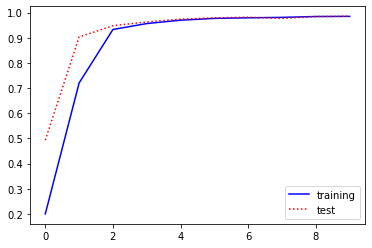

In [18]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

Test Accuracy 0.9855로 꽤 좋은 성능을 보이고 있네요!!
